In [1]:
pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/15/aa/3f4c7bcee2057a76562a5b33ecbd199be08cdb4443a02e26bd2c3cf6fc39/pip-23.3.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install tensorflow matplotlib

In [3]:
!pip install opendatasets

In [4]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install numpy opencv-python Pillow

In [6]:
import opendatasets as od
import cv2
import imghdr
import tensorflow as tf
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from shutil import move
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU config OK")
else:
    print("Error using GPU, CPU will be used")
tf.keras.backend.clear_session()

In [7]:
#Load the data from kaggle
image_path = "https://www.kaggle.com/datasets/csafrit2/plant-leaves-for-image-classification"

In [8]:
od.download(image_path)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  ibebenedict


Your Kaggle Key:

  ································


100%|██████████| 6.56G/6.56G [00:52<00:00, 134MB/s] 


In [9]:
#Contents of the loaded data
!ls plant-leaves-for-image-classification/Plants_2

'images to predict'   test   train   valid


In [10]:
# Path to the Plants_2 and General_plant directory, and the Creation of General_plant directory
plants_2_path = "plant-leaves-for-image-classification/Plants_2"
general_plant_path = "plant-leaves-for-image-classification/Plants_2/General_plant"
os.makedirs(general_plant_path, exist_ok=True)

In [11]:
#Create directories for healthy and diseased plants
healthy_plants_path = os.path.join(general_plant_path, "healthy_plants")
diseased_plants_path = os.path.join(general_plant_path, "diseased_plants")
os.makedirs(healthy_plants_path, exist_ok=True)
os.makedirs(diseased_plants_path, exist_ok=True)

In [12]:
# Iterate through each split directory (train, test, valid)
for split in ["train", "test", "valid"]:
    split_path = os.path.join(plants_2_path, split)

    # Iterate through each plant type folder in the split directory
    for folder_name in os.listdir(split_path):
        folder_path = os.path.join(split_path, folder_name)

        # Check if the folder name contains 'healthy' or 'diseased'
        if 'healthy' in folder_name.lower():
            destination_path = healthy_plants_path
        elif 'diseased' in folder_name.lower():
            destination_path = diseased_plants_path
        else:
            continue  # Skip folders that don't match the criteria

        # Move images to the appropriate destination
        for filename in os.listdir(folder_path):
            source_file = os.path.join(folder_path, filename)
            destination_file = os.path.join(destination_path, f"{folder_name}_{filename}")
            shutil.copy(source_file, destination_file)

print("Images grouped into healthy_plants and diseased_plants.")

Images grouped into healthy_plants and diseased_plants.


In [13]:
os.listdir(os.path.join("plant-leaves-for-image-classification/Plants_2/General_plant"))

['healthy_plants', 'diseased_plants']

In [14]:
#CHECK FOR CORRUPTED FILES
import os

num_skipped = 0

for folder in ("diseased_plants", "healthy_plants"):
    folder_path = os.path.join(general_plant_path, folder)
    for f_name in os.listdir(folder_path):
        f_path = os.path.join(folder_path, f_name)

        # Check if the current item is a file
        if os.path.isfile(f_path):
            try:
                with open(f_path, "rb") as f_obj:
                    has_jfif = b"JFIF" in f_obj.peek(10)
            except Exception as e:
                print(f"Error processing {f_path}: {e}")
                continue

            if not has_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(f_path)

print(f"Deleted {num_skipped} images.")


Deleted 0 images.


In [15]:
#View the re-organized data
!ls plant-leaves-for-image-classification/Plants_2

 General_plant	'images to predict'   test   train   valid


In [16]:
import os
import pandas as pd

# Set the path to the directories
healthy_plants_path = "plant-leaves-for-image-classification/Plants_2/General_plant/healthy_plants"
diseased_plants_path = "plant-leaves-for-image-classification/Plants_2/General_plant/diseased_plants"

# Function to create a dataframe from files in a directory
def create_dataframe_from_directory(directory, label):
    data = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        data.append({"image": file_path, "class": label})
    return pd.DataFrame(data)

# Create dataframes for healthy and diseased plants
healthy_df = create_dataframe_from_directory(healthy_plants_path, label="healthy")
diseased_df = create_dataframe_from_directory(diseased_plants_path, label="diseased")

# Combine the dataframes
combined_df = pd.concat([healthy_df, diseased_df], ignore_index=True)

# Display the first few rows of the combined dataframe
print(combined_df.head())

                                               image    class
0  plant-leaves-for-image-classification/Plants_2...  healthy
1  plant-leaves-for-image-classification/Plants_2...  healthy
2  plant-leaves-for-image-classification/Plants_2...  healthy
3  plant-leaves-for-image-classification/Plants_2...  healthy
4  plant-leaves-for-image-classification/Plants_2...  healthy


neg, pos = np.bincount(combined_df['class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

In [17]:
print(combined_df['class'].isna().sum())

0


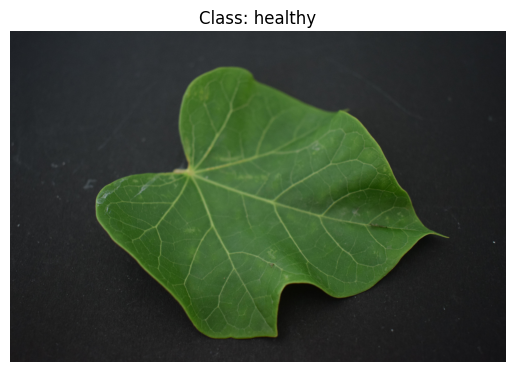

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Choose an index to get a specific image from the dataframe
index_to_display = 0  # Change this index to view a different image

# Get the image path and class label from the dataframe
image_path = combined_df.loc[index_to_display, 'image']
class_label = combined_df.loc[index_to_display, 'class']

# Load and display the image
img = mpimg.imread(image_path)

plt.imshow(img)
plt.title(f'Class: {class_label}')
plt.axis('off')  # Turn off axis labels
plt.show()

In [19]:
combined_df['class'] = combined_df['class'].replace('healthy', 1)
combined_df['class'] = combined_df['class'].replace('diseased', 0)

In [20]:
combined_df

,image,class
0,plant-leaves-for-image-classification/Plants_2...,1
1,plant-leaves-for-image-classification/Plants_2...,1
2,plant-leaves-for-image-classification/Plants_2...,1
3,plant-leaves-for-image-classification/Plants_2...,1
4,plant-leaves-for-image-classification/Plants_2...,1
...,...,...
4489,plant-leaves-for-image-classification/Plants_2...,0
4490,plant-leaves-for-image-classification/Plants_2...,0
4491,plant-leaves-for-image-classification/Plants_2...,0
4492,plant-leaves-for-image-classification/Plants_2...,0


In [21]:
#Initialize and define the batch size
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

batch_size = 128
target_size = (150, 150)

In [22]:
# Create a TensorFlow dataset from the DataFrame
image_dataset = tf.data.Dataset.from_tensor_slices((combined_df['image'].values, combined_df['class'].values))

In [23]:
def load_and_preprocess_image(image_path, label):
    # Load and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)

    # Explicitly set the shape of the image
    image.set_shape((None, None, 3))

    # Preprocess the image (add any additional preprocessing steps if needed)
    image = tf.image.resize(image, (150, 150))
    
    return image, label

In [24]:
# Map the preprocessing function to the dataset
image_dataset = image_dataset.map(load_and_preprocess_image)

In [25]:
# Shuffle and batch the dataset
image_dataset = image_dataset.shuffle(buffer_size=len(combined_df)).batch(batch_size=batch_size)

In [26]:
# Create an iterator for the augmented dataset
data_iterator = image_dataset.as_numpy_iterator()

In [27]:
#Loop through the pipeline, or load the images in batches
batch = data_iterator.next()

In [28]:
batch[0].shape

(128, 150, 150, 3)

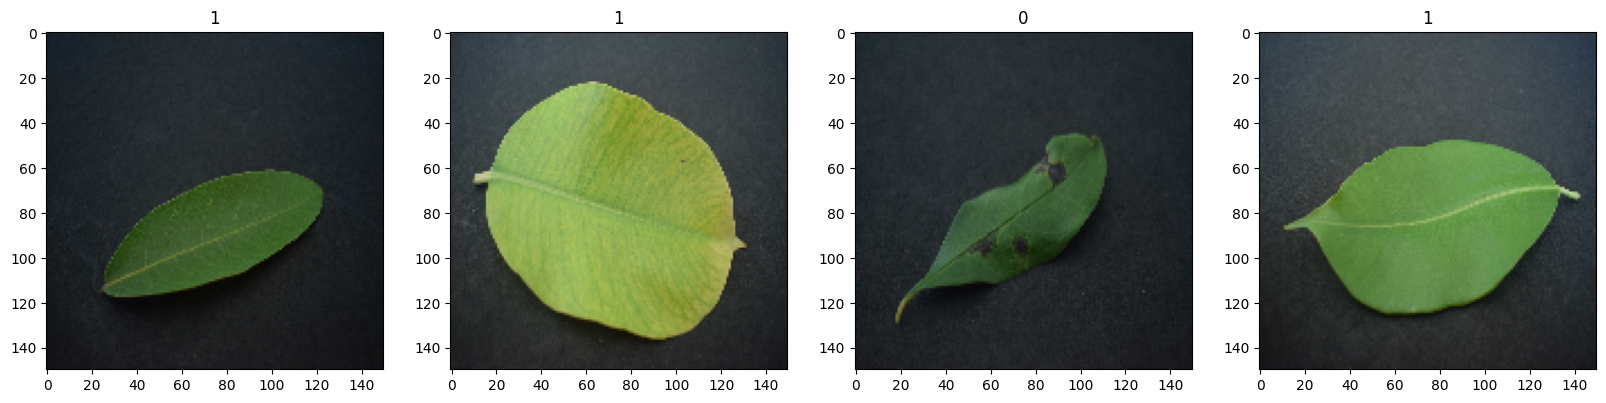

In [29]:
#View a batch using matplotlib to see the diseased and healthy class
import matplotlib.pyplot as plt

# Explicitly specify both nrows and ncols for clarity
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))  # Assuming you want all subplots in one row

# Check if `batch[0]` has at least 4 images
if len(batch[0]) >= 4:
    for idx, img in enumerate(batch[0][:4]):
        ax[idx].imshow(img/255)  # Directly use the img if it's already a numpy array
        ax[idx].set_title(str(batch[1][idx]))  # Cast the title to string in case it's not already
    plt.show()
else:
    print("The batch does not contain enough images to display 4 images.")

In [30]:
# Data augmentation
plant_augmentation_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(150, 150),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [31]:
image_dataset_augmented = image_dataset.map(lambda x, y: (plant_augmentation_rescale(x, training=True), y))

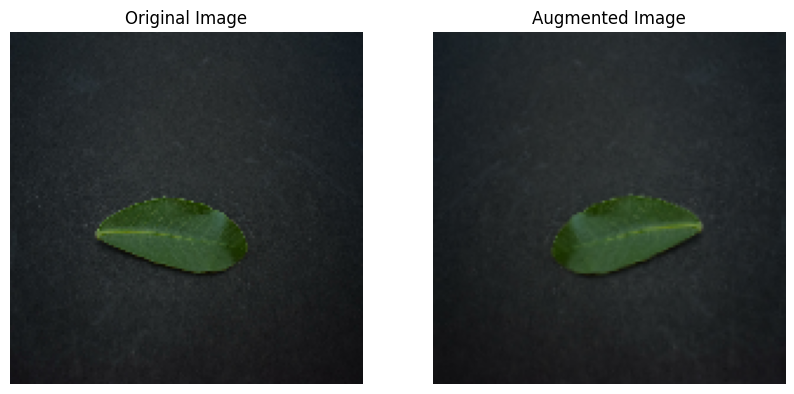

In [32]:
import matplotlib.pyplot as plt

# Take one batch of images and labels
for images, labels in image_dataset.take(1):
    # Original image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title("Original Image")
    plt.axis("off")


  # Augmented image
    augmented_images = plant_augmentation_rescale(images, training=True)
    plt.subplot(1, 2, 2)
    # The pixel values should be clipped to the range [0, 1] for proper display
    plt.imshow(tf.clip_by_value(augmented_images[0]/255, 0, 1).numpy())
    plt.title("Augmented Image")
    plt.axis("off")

plt.show()

In [33]:
# Assuming 80% training, 10% validation, and 10% test split
train_size = int(0.8 * len(image_dataset_augmented))
val_size = int(0.1 * len(image_dataset_augmented))
test_size = len(image_dataset_augmented) - train_size - val_size

In [34]:
# Split the dataset
train_data = image_dataset_augmented.take(train_size)
val_data = image_dataset_augmented.skip(train_size).take(val_size)
test_data = image_dataset_augmented.skip(train_size + val_size)

In [35]:
# Calculate the number of batches in the training dataset
num_batches_train = train_data.cardinality().numpy()

# Calculate the total number of samples in the training dataset
num_samples_train = num_batches_train * batch_size

print("Number of batches in the training dataset:", num_batches_train)
print("Number of samples in the training dataset:", num_samples_train)

Number of batches in the training dataset: 28
Number of samples in the training dataset: 3584


In [36]:
train_data

<_TakeDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [37]:
#Initialize the training sequence
plant_model = Sequential()

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Rescaling, Resizing
import tensorflow as tf
from tensorflow.keras.regularizers import l2



# Resizing layer for standardizing input size
plant_model.add(Resizing(150, 150, input_shape=(150, 150, 3)))

# Rescaling layer for normalization
plant_model.add(Rescaling(1./255))

# Convolutional block 1
plant_model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.01)))
plant_model.add(Activation('relu'))
plant_model.add(MaxPooling2D())

# Convolutional block 2
plant_model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.01)))
plant_model.add(Activation('relu'))
plant_model.add(MaxPooling2D())

# Convolutional block 3
plant_model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=l2(0.01)))
plant_model.add(Activation('relu'))
plant_model.add(MaxPooling2D())

# Convolutional block 4
plant_model.add(Conv2D(384, (3,3), padding='same', kernel_regularizer=l2(0.01)))
plant_model.add(Activation('tanh'))
plant_model.add(MaxPooling2D())

# Flatten and Dense layers
plant_model.add(Flatten())
plant_model.add(Dense(512, kernel_regularizer=l2(0.01)))
plant_model.add(Activation('relu'))
plant_model.add(Dropout(0.5))
plant_model.add(Dense(1, activation='sigmoid'))

# Compile the model with the best learning rate found from tuning
plant_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Summary of the model
plant_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 activation (Activation)     (None, 150, 150, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 128)       73856     
                                                      

In [39]:
log_dir='logs'

In [40]:
tenboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [41]:
#Initialize earrly stops when there are no improvement
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=10,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)

In [42]:
# Assuming you already have your image dataset loaded into 'image_dataset_augmented'
# Fit the model
hist = plant_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)]
)

Epoch 1/20
28/28 [==============================] - 435s 8s/step - loss: 4.6921 - accuracy: 0.5427 - val_loss: 1.3386 - val_accuracy: 0.5312
Epoch 2/20
28/28 [==============================] - 426s 8s/step - loss: 0.9190 - accuracy: 0.6124 - val_loss: 0.7371 - val_accuracy: 0.6615
Epoch 3/20
28/28 [==============================] - 425s 8s/step - loss: 0.7028 - accuracy: 0.6722 - val_loss: 0.6275 - val_accuracy: 0.7266
Epoch 4/20
28/28 [==============================] - 426s 8s/step - loss: 0.7120 - accuracy: 0.6830 - val_loss: 0.7216 - val_accuracy: 0.6875
Epoch 5/20
28/28 [==============================] - 428s 8s/step - loss: 0.6972 - accuracy: 0.6794 - val_loss: 0.6691 - val_accuracy: 0.6797
Epoch 6/20
28/28 [==============================] - 427s 8s/step - loss: 0.6583 - accuracy: 0.7017 - val_loss: 0.6547 - val_accuracy: 0.7135
Epoch 7/20
28/28 [==============================] - 430s 8s/step - loss: 0.6556 - accuracy: 0.7160 - val_loss: 0.6436 - val_accuracy: 0.7161
Epoch 8/20
28

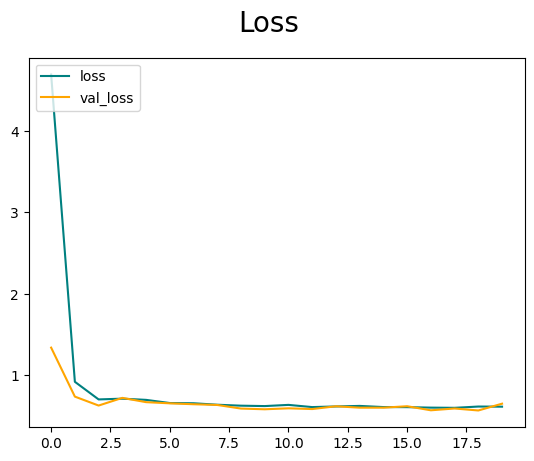

In [43]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

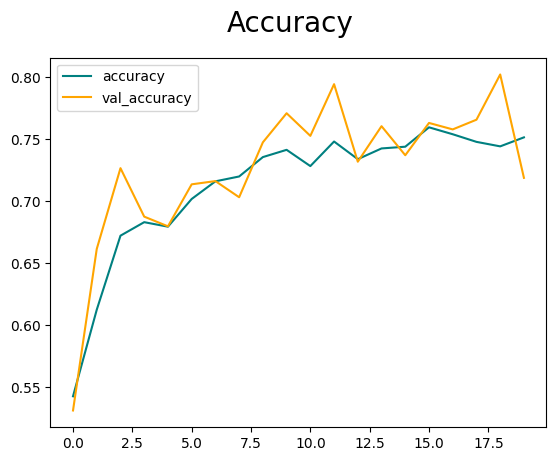

In [44]:
#Resize the image
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [45]:
best_epoch = hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])) + 1
best_val_accuracy = hist.history['val_accuracy'][best_epoch - 1]

print(f"Best epoch: {best_epoch}")
print(f"Best validation accuracy: {best_val_accuracy * 100:.2f}%")

Best epoch: 19
Best validation accuracy: 80.21%


In [46]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [47]:
model_precision = Precision()
model_recall = Recall()
model_accuracy = BinaryAccuracy()

In [48]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = plant_model.predict(X)
    model_precision.update_state(y, yhat)
    model_recall.update_state(y, yhat)
    model_accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 446ms/step


In [49]:
print(f'Precision:{model_precision.result().numpy()}, Recall:{model_recall.result().numpy()}, Accuracy:{model_accuracy.result().numpy()}')

Precision:0.7952380776405334, Recall:0.6007194519042969, Accuracy:0.7072243094444275


In [50]:
saved_model = plant_model.save('plant_disease.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
input_size = (150, 150)

In [52]:
test_loss, test_acc = plant_model.evaluate(test_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

5/5 [==============================] - 214s 292ms/step - loss: 0.6462 - accuracy: 0.7205
Test Loss: 0.6462225914001465
Test Accuracy: 0.7205322980880737


In [53]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as img


# Another test